In [1]:
#Conexió al Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CARREGA DE DADES I ETL PER MODELS DE PREDICCIÓ DE LA EVAPOTRASPIRACIÖ

Es carreguen i concatenen dades de 14 estacions meteorologiques, que representen a les 14 zones climatiques que el METEOCAT diferencia a Catalunya.

Els diferents arxius s'han extret previament de maneral manual, per a cadascuna de les estacions desde la pagina de estacions agrometeorologiques

https://ruralcat.gencat.cat/web/guest/agrometeo.estacions?p_p_id=AgrometeoEstacions_WAR_AgrometeoEstacions&p_p_lifecycle=1&p_p_state=normal&p_p_mode=view&_AgrometeoEstacions_WAR_AgrometeoEstacions_action=goEstacion&p_auth=LPsCiqTt

Els periodes son de 2011 a 2024

In [2]:
import os
import pandas as pd

directori = '/content/drive/MyDrive/Colab Notebooks/data/data_EVO'

#CArrega i unio d'0arxius
def unir_xls(path):
    restultat = {}
    for nom_carpeta in os.listdir(directori):
        ruta_carpeta = os.path.join(directori, nom_carpeta)
        if os.path.isdir(ruta_carpeta):
            tots_arxius = [f for f in os.listdir(ruta_carpeta) if f.endswith('.xls')]

            if tots_arxius:
                df_llista = []
                for arxiu in tots_arxius:
                    ruta_archivo = os.path.join(ruta_carpeta, arxiu)
                    df = pd.read_excel(ruta_archivo)
                    df['CLIMA'] = nom_carpeta
                    df_llista.append(df)

                restultat[nom_carpeta] = pd.concat(df_llista, ignore_index=True)

    return restultat


dfs = unir_xls(directori)

WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (82433) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (82433) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (82433) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file size (81921) not 512 + multiple of sector size (512)
WARNING *** file siz

In [4]:
#Assignació de nom clima
for i in dfs:
    globals()[i] = dfs[i]

In [5]:
#Concatenació de les dades de totes les estacions i creació datraframes
DF_TOTAL = pd.concat(dfs.values(), ignore_index=True)

In [6]:
DF_TOTAL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71596 entries, 0 to 71595
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   D�a                                    71596 non-null  object 
 1   Temperatura mitjana diària             71596 non-null  object 
 2   Temperatura màxima diària + hora       71596 non-null  object 
 3   Temperatura mínima diària + hora       71596 non-null  object 
 4   Velocitat escalar del vent a 2m        71596 non-null  float64
 5   Humitat relativa mitjana diària        71596 non-null  object 
 6   Humitat relativa màxima diària + data  71596 non-null  object 
 7   Precipitació acumulada diària          71596 non-null  float64
 8   Irradiació solar global diària         71596 non-null  object 
 9   Evapotranspiració de referència        71596 non-null  object 
 10  CLIMA                                  71596 non-null  object 
 11  Ir

In [7]:
#Renombar columnes
renom = {
    'D�a': 'Dia',
    'Temperatura mitjana diària': 'Tm',
    'Temperatura màxima diària + hora': 'Tmax',
    'Temperatura mínima diària + hora': 'Tmin',
    'Velocitat escalar del vent a 2m': 'Velocitat_vent',
    'Humitat relativa mitjana diària': 'HRmd',
    'Humitat relativa màxima diària + data': 'HRmax',
    'Precipitació acumulada diària': 'Precipitacio',
    'Irradiació solar global diària': 'Irradiacio_solar',
    'Evapotranspiració de referència': 'ETo',
    'CLIMA': 'Clima',
    'Irradiació neta diària': 'Irradiacio_neta'
}

EVO = DF_TOTAL.rename(columns=renom)
# Eliminem variable Irradiacio neta. No es troba a totes les estacions
EVO = EVO.drop('Irradiacio_neta', axis=1)

In [8]:
# Transformació variables

EVO['Dia'] = pd.to_datetime(EVO['Dia'], format='%d/%m/%Y', errors='coerce')

EVO['Clima'] = pd.Categorical(EVO['Clima'])

numeric_cols = ['Tm', 'Tmax', 'Tmin', 'Velocitat_vent', 'HRmd', 'HRmax', 'Precipitacio', 'Irradiacio_solar', 'ETo']
for col in numeric_cols:
    EVO[col] = pd.to_numeric(EVO[col], errors='coerce')

S'incporpora el valor de la Latitud de cada estació.
També s'incorpora el nom de la EMA

In [9]:
#Info a incorporar
lat_EMA = {
    'LM': {'Lat': 41.30728, 'EMA': 'Vila-rodona'},
    'CS': {'Lat': 41.51909, 'EMA': 'Torres del Segre'},
    'CH': {'Lat': 42.03947, 'EMA': 'Perefita'},
    'CSH': {'Lat': 41.83094, 'EMA': 'Castellnou del Bages'},
    'LC': {'Lat': 41.38197, 'EMA': 'Vallirana'},
    'LS': {'Lat': 41.80857, 'EMA': 'Castell Aro'},
    'PLS': {'Lat': 41.87449, 'EMA': 'Cassà de la Selva'},
    'PLC': {'Lat': 41.56568, 'EMA': 'Sabadell Parc Agrari'},
    'PLM': {'Lat': 41.39241, 'EMA': 'Espluga de Francolí'},
    'PPOC': {'Lat': 42.14557, 'EMA': 'Vall d en Bas'},
    'PPC': {'Lat': 42.08032, 'EMA': 'La Quar'},
    'PPOR': {'Lat': 42.13924, 'EMA': 'Sant Romà Abellà'},
    'POR': {'Lat': 42.39848, 'EMA': 'Núria'},
    'POC': {'Lat': 42.46602, 'EMA': 'Boí'}
}

In [10]:
#Funció lambda per incorporar dades adicionals.
EVO['Lat'] = EVO['Clima'].map(lambda x: lat_EMA.get(x, {}).get('Lat'))
EVO['EMA'] = EVO['Clima'].map(lambda x: lat_EMA.get(x, {}).get('EMA'))

In [11]:
#Analisis de nulls
null_counts = EVO.isnull().sum()
print(null_counts)

Dia                   0
Tm                   43
Tmax                  5
Tmin                  4
Velocitat_vent        0
HRmd                 44
HRmax                17
Precipitacio          0
Irradiacio_solar     19
ETo                 480
Clima                 0
Lat                   0
EMA                   0
dtype: int64


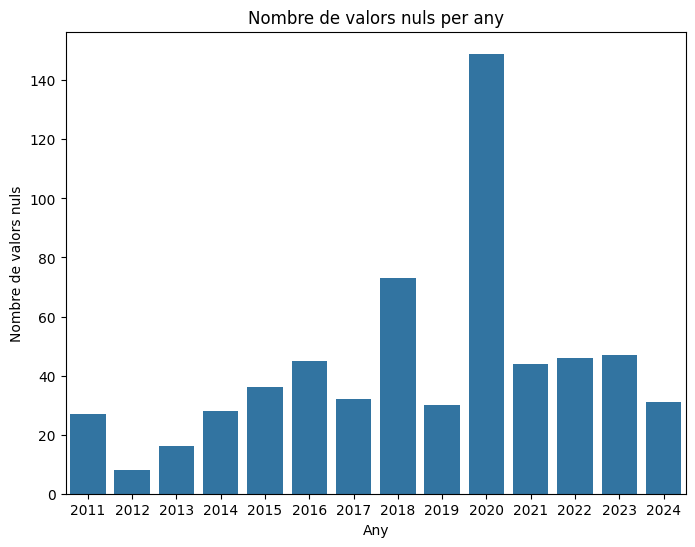

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
EVO['Any'] = EVO['Dia'].dt.year

# Distribució de null per anys

EVO['Num_Nuls'] = EVO.isnull().sum(axis=1)

nuls_per_any = EVO.groupby('Any')['Num_Nuls'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Any', y='Num_Nuls', data=nuls_per_any)
plt.title('Nombre de valors nuls per any')
plt.xlabel('Any')
plt.ylabel('Nombre de valors nuls')
plt.show()

<ipython-input-14-e08cfd57d5d9>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nuls_per_clima = EVO.groupby('Clima')['Num_Nuls'].sum().reset_index()


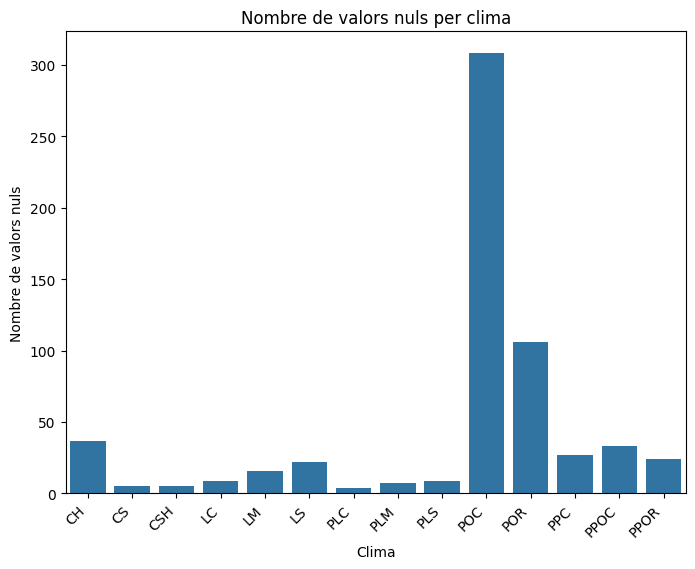

In [14]:
# Dist5ribució de null per clima

nuls_per_clima = EVO.groupby('Clima')['Num_Nuls'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Clima', y='Num_Nuls', data=nuls_per_clima)
plt.title('Nombre de valors nuls per clima')
plt.xlabel('Clima')
plt.ylabel('Nombre de valors nuls')
plt.xticks(rotation=45, ha='right')
plt.show()

Un cop analitzats els valors null, es decideix extreure dels models les estacions meteorologiques del climes PIRIENU OCCIDENTAL I ORIENTAL.

In [15]:
#S'exclOUEN les zones climàtiques del pririenu oriental i occidental
EVO = EVO[~EVO['Clima'].isin(['POC', 'POR'])]

In [19]:
numeric_cols = EVO.select_dtypes(include=['number']).columns
EVO[numeric_cols] = EVO[numeric_cols].round(2)
EVO[numeric_cols] = EVO[numeric_cols].apply(pd.to_numeric)
EVO.head()

,Dia,Tm,Tmax,Tmin,Velocitat_vent,HRmd,HRmax,Precipitacio,Irradiacio_solar,ETo,Clima,Lat,EMA,Any
0,2021-01-01,6.1,8.3,4.2,2.2,74.0,85.0,0.0,3.8,0.51,LM,41.30728,Vila-rodona,2021
1,2021-01-02,4.2,7.1,1.7,3.8,61.0,76.0,0.0,8.5,0.77,LM,41.30728,Vila-rodona,2021
2,2021-01-03,4.6,8.7,0.3,3.1,51.0,63.0,0.0,9.3,1.02,LM,41.30728,Vila-rodona,2021
3,2021-01-04,4.4,8.9,0.8,2.2,65.0,80.0,0.0,9.3,0.93,LM,41.30728,Vila-rodona,2021
4,2021-01-05,2.5,6.3,-1.2,2.1,72.0,88.0,0.0,9.3,0.81,LM,41.30728,Vila-rodona,2021


In [21]:
EVO.to_csv('/content/drive/MyDrive/Colab Notebooks/data/data_EVO/EVO.csv', index=False)